In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_rho_times_P_x_t_fn, CDF_v_change_till_stim_trunc_adj_fn, PDF_t_v_change
from scipy.integrate import trapezoid as trapz

In [2]:
import numpy as np

def erf_(x):
    """
    Approximate the error function using a numerical approximation (Abramowitz & Stegun formula).
    
    Parameters:
        x (float or np.ndarray): The input value(s) for the error function.
    
    Returns:
        float or np.ndarray: The approximated error function value(s).
    """
    # Constants for the approximation
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    x = np.asarray(x)  # Convert input to NumPy array if it isn't already
    sign = np.sign(x)  # Get sign for element-wise handling
    x = np.abs(x)

    # Approximation formula
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x * x)

    return sign * y


# data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

In [4]:
df_led_on = df[df['LED_trial'] == 0]
df_led_on_aborts = df_led_on[df_led_on['abort_event'] == 3]

# likelihood helper funcs

In [5]:
import numpy as np

def d_A_RT_SCALAR(a, t):
    """
    Calculate the standard PA probability density function for a scalar time value.

    Parameters:
        a (float): Scalar parameter.
        t (float): Time value (must be > 0).

    Returns:
        float: The computed pdf value (0 if t <= 0).
    """
    if t <= 0:
        return 0.0
    p = (1.0 / np.sqrt(2 * np.pi * (t**3))) * np.exp(-((1 - a * t)**2) / (2 * t))
    return p


import numpy as np

def stupid_f_integral_SCALAR(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression for scalar inputs.

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (float): Time value.
        tp (float): A shifted time value.

    Returns:
        float: The evaluated integral expression.
    """
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * np.pi * a1 * np.sqrt(tp * t**3))
    F02 = 1.0 / (4 * np.pi * a2 * np.sqrt(tp * t**3))

    if a1 < 0:
        print(f'a1 = {a1}')
        print(f't = {t}, tp = {tp}')
        raise ValueError("a1 must be positive.")
    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * np.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * np.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * np.sqrt(np.pi) * np.exp(T11 + c1) * (erf_(T12) + 1) + np.exp(T13 + c1))
    I2 = F02 * (T22 * np.sqrt(np.pi) * np.exp(T21 + c2) * (erf_(T22) + 1) + np.exp(T23 + c2))

    STF = I1 - I2
    return STF


def PA_with_LEDON_2_SCALAR(t, v, vON, a, tfix, tled, delta_i, delta_m):
    """
    Compute the PA pdf by combining contributions before and after LED onset for scalar inputs.

    Parameters:
        t (float): Time value.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        float: The combined PA pdf value.
    """
    # Check if the time (with fixation) is before the LED onset.
    if (t + tfix) <= (tled + 1e-6):
        # Use the scalar version of d_A_RT: note that d_A_RT_SCALAR must be defined.
        result = d_A_RT_SCALAR(v * a, (t - (delta_i + delta_m) + tfix) / (a**2)) / (a**2)
    else:
        # Use the scalar version of stupid_f_integral: note that stupid_f_integral_SCALAR must be defined.
        result = stupid_f_integral_SCALAR(v, vON, a, t + tfix - delta_m  - tled, tled + tfix - delta_i )
    return result

In [6]:
import numpy as np
import math
import numpy as np


def d_A_RT_VEC(a, t):
    """
    Calculate the standard PA probability density function (vectorized).

    Parameters:
        a (float): Scalar parameter.
        t (numpy.ndarray): Time values (must be > 0).

    Returns:
        numpy.ndarray: The computed pdf values (0 where t <= 0).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    p = np.zeros_like(t)
    valid_indices = t > 0
    p[valid_indices] = (1.0 / np.sqrt(2 * np.pi * (t[valid_indices]**3))) * np.exp(-((1 - a * t[valid_indices])**2) / (2 * t[valid_indices]))
    return p

def stupid_f_integral_VEC(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression (vectorized).

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (numpy.ndarray): Time values.
        tp (numpy.ndarray): A shifted time values.

    Returns:
        numpy.ndarray: The evaluated integral expressions.
    """
    t = np.asarray(t)
    tp = np.asarray(tp)
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * np.pi * a1 * np.sqrt(tp * t**3))
    F02 = 1.0 / (4 * np.pi * a2 * np.sqrt(tp * t**3))

    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * np.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * np.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * np.sqrt(np.pi) * np.exp(T11 + c1) * (erf_(T12) + 1) + np.exp(T13 + c1))
    I2 = F02 * (T22 * np.sqrt(np.pi) * np.exp(T21 + c2) * (erf_(T22) + 1) + np.exp(T23 + c2))

    STF = I1 - I2
    return STF


def PA_with_LEDON_2_VEC(t, v, vON, a, tfix, tled, delta_i, delta_m):
    """
    Compute the PA pdf by combining contributions before and after LED onset (vectorized).

    Parameters:
        t (numpy.ndarray): Time values.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        numpy.ndarray: The combined PA pdf values.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    
    before_led = (t + tfix) <= (tled + 1e-6)
    result[before_led] = d_A_RT_VEC(v * a, (t[before_led] - (delta_i + delta_m) + tfix) / (a**2)) / (a**2)
    
    # Compute the time difference for the post-LED condition
    t_post_led = t[~before_led] + tfix - delta_m - tled
    tp_post_led = tled + tfix - delta_i

    # Mask for valid time points (ensuring t_post_led is non-negative)
    valid_indices = t_post_led >= 0
    
    # Compute only for valid indices
    result[~before_led][valid_indices] = stupid_f_integral_VEC(v, vON, a, t_post_led[valid_indices], tp_post_led)

    return result


# likelihood

In [7]:
T_trunc = 0.3

In [8]:
V_A = 1.59
theta_A = 2.53
# total proactive delay
total_proactive_delay = -0.187

In [9]:
t_pts_for_trunc = np.arange(0, T_trunc, 0.001)
def compute_loglike(row, post_LED_drift, motor_delay):
    delta_i = total_proactive_delay - motor_delay
    tfix = 0

    rt = row['timed_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    if rt < T_trunc:
        likelihood = 0
    else:
        if rt - motor_delay - t_LED < 0:
            likelihood = 0
        else:
            likelihood = PA_with_LEDON_2_SCALAR(rt, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
    
        # truncation factor
        PA_vec = PA_with_LEDON_2_VEC(t_pts_for_trunc, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
        trunc_factor = 1 - trapz(PA_vec, t_pts_for_trunc)
        likelihood /= trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50
    
    return np.log(likelihood)
    

def vbmc_loglike_fn(params):
    post_LED_drift, motor_delay = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, post_LED_drift, motor_delay)\
                                      for _, row in df_led_on_aborts.iterrows())
    
    return np.sum(all_loglike)
    

# bounds

In [10]:
post_LED_drift_bounds = [1, 10]
post_LED_drift_plausible_bounds = [1.5, 3.5]

motor_delay_bounds = [0, 0.1]
motor_delay_plausible_bounds = [0.01, 0.07]

# prior

In [11]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    post_LED_drift, motor_delay = params

    post_LED_drift_logpdf = trapezoidal_logpdf(post_LED_drift, post_LED_drift_bounds[0], post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1], post_LED_drift_bounds[1])
    motor_delay_logpdf = trapezoidal_logpdf(motor_delay, motor_delay_bounds[0], motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1], motor_delay_bounds[1])

    return post_LED_drift_logpdf + motor_delay_logpdf

# joint

In [12]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + vbmc_loglike_fn(params)

# run vbmc

In [13]:
lb = [post_LED_drift_bounds[0], motor_delay_bounds[0]]
ub = [post_LED_drift_bounds[1], motor_delay_bounds[1]]

plb = [post_LED_drift_plausible_bounds[0], motor_delay_plausible_bounds[0]]
pub = [post_LED_drift_plausible_bounds[1], motor_delay_plausible_bounds[1]]

np.random.seed(42)
post_LED_drift_0 = np.random.uniform(post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1])
motor_delay_0 = np.random.uniform(motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1])

x_0 = np.array([post_LED_drift_0, motor_delay_0])

vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting lower bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10     -794203.86      9156.03   3077573.30        2        inf     start warm-up
     1         15     -792740.93      1332.12     27551.80        2        inf     
     2         20     -788473.60       138.81      6061.72        2   1.58e+05     
     3         25     -787455.98      1082.98      1710.38        2   4.73e+04     
     4         30     -787297.37       273.99      6106.28        2   1.45e+05     
     5         35     -786760.85       348.29       423.33        2   1.29e+04     
     6         40     -786030.95       138.46     24994.47        2   5.92e+05     
    

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    35        185     -785086.26         1.33        14.78        7        372     
    36        190     -785085.42         0.34         0.94        8         26     
    37        195     -785029.03        50.53         6.86        8        518     
    38        200     -784965.64       321.19      2868.70        8   6.89e+04     
   inf        200     -784945.88       504.66      3044.91       50         26     finalize
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -784945.878 +/-504.665.
Caution: Returned variational solution may have not converged.


# corner

Too few points to create valid contours


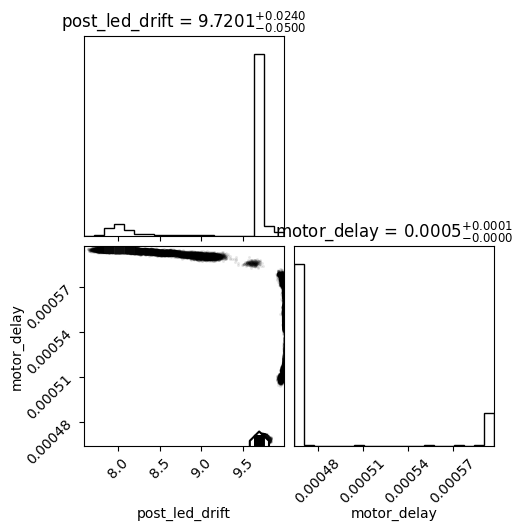

In [14]:
import corner
vp_samples = vp.sample(int(1e6))[0]
post_led_drift_samp = vp_samples[:, 0]
motor_delay_samp = vp_samples[:, 1]

# combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
# param_labels = ['base_V_A', 'theta_A', 't_A_aff']

combined_samples = np.transpose(np.vstack((post_led_drift_samp, motor_delay_samp)))
param_labels = ['post_led_drift', 'motor_delay']

corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");
